In [7]:
import os.path

import nengo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import LogLocator, MaxNLocator
import pandas as pd
from psyrun.io import load_dict_h5 as load_results
import seaborn as sns

%matplotlib inline

In [4]:
import sys
sys.path.append('psy-tasks')
from spaopt.optimization import SubvectorRadiusOptimizer

In [5]:
sns.set('paper', 'ticks')

labelpad = 1

rcParams['mathtext.fontset'] = 'stixsans'

single_col_size = (3.35, 3.35 * 0.618)
double_col_size = (7.08, 7.08 * 0.618)
four_by_two_size = (7.08, 8.75)

# Data loading

In [8]:
def load_datafile(filename):
    data = load_results(filename)
    n_tiles = max(np.atleast_2d(x).shape[1] for x in data.values())
    data = {k: np.tile(v, (n_tiles, 1)).T.flat if len(v.shape) == 1 else v.flat for k, v in data.items()}
    return pd.DataFrame({k: v for k, v in data.items()})

def load_data(name):
    def get_set_group_fn():
        groups = {}
        def set_group(x):
            head = x.iloc[0]
            group_idx = (head['n_neurons'], head['d'])
            try:
                group = groups[group_idx]
            except KeyError:
                group = len(groups)
                groups[group_idx] = group
            x['group'] = group
            return x
        return set_group

    data = pd.concat((
        load_datafile(os.path.join('psywork', name, 'result.h5')),
        load_datafile(os.path.join('psywork', name + '_less_neurons', 'result.h5'))))
    data['reduced_neurons'] = data['reduced_neurons'].fillna(data['n_neurons']).astype(int)
    data = pd.melt(data.query('t > 0.5'), id_vars=['n_neurons', 'reduced_neurons', 'd', 'seed', 'trial', 't']).query(
        'n_neurons == reduced_neurons or variable == "optimized"').groupby(
        ['n_neurons', 'd', 'variable', 'reduced_neurons']).apply(get_set_group_fn())
    return data

# Plotting functions

In [9]:
def plot_accuracy_dists(name):
    with sns.axes_style('whitegrid'):
        data = load_data(name)
        a = data.query('n_neurons == reduced_neurons and variable == "default"').groupby(
            ['n_neurons', 'd'])['value'].mean()
        b = data.query('n_neurons == reduced_neurons and variable == "optimized"').groupby(
            ['n_neurons', 'd'])['value'].mean()
        print a / b
        
        g = sns.FacetGrid(
            data.rename(columns={
                'reduced_neurons': 'Number of neurons / $D$',
                'value': 'Error ($L_2$ norm)',
            }), col='group', sharex=False, size=0.67 * double_col_size[1],
            aspect=double_col_size[0] / double_col_size[1] / 0.67 / 3., legend_out=False)
        g.map(
            sns.violinplot, 'Number of neurons / $D$', 'Error ($L_2$ norm)', 'variable',
            inner='quartile', linewidth=1, scale='width')
        g.add_legend(title='Radius', frameon=True)
        for ax, (_, facet_data) in zip(g.axes[0], g.facet_data()):
            ax.set_title('$D={d}$'.format(d=int(facet_data['d'].iloc[0])))
            ax.set_xticks([0, 1.2])
        return g

# SqrtBeta distribution

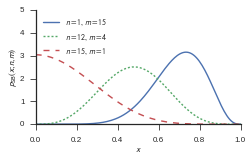

In [10]:
rs = np.linspace(0, 1, 150)
fig = plt.figure(figsize=single_col_size)
plt.plot(rs, nengo.dists.SqrtBeta(8, 8).pdf(rs), label=r"$n=1,\ m=15$")
plt.plot(rs, nengo.dists.SqrtBeta(12, 4).pdf(rs), dashes=(2, 2), label=r"$n=12,\ m=4$")
plt.plot(rs, nengo.dists.SqrtBeta(15, 1).pdf(rs), dashes=(6, 6), label=r"$n=15,\ m=1$")
plt.ylim(0, 5)
plt.legend(loc='upper left')
plt.xlabel(r"$x$", labelpad=labelpad)
plt.ylabel(r"$p_{\mathrm{SB}}(x; n, m)$", labelpad=labelpad)
sns.despine()
plt.tight_layout(pad=0.1)

In [7]:
fig.savefig('sqrtbeta.eps')

# Error estimate

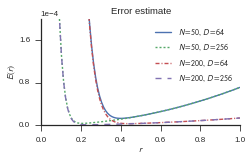

In [11]:
xs = np.linspace(0, 1, 100)
fig = plt.figure(figsize=single_col_size)
for n_neurons, d, dashes in [(50, 64, ()), (50, 256, (2, 2)), (200, 64, (4, 2, 1, 2)), (200, 256, (6, 6))]:
    plt.plot(xs, SubvectorRadiusOptimizer(
        n_neurons, 1, seed=39).sp_subvector_error(xs, d),
        dashes=dashes, label=r"$N={},\ D={}$".format(n_neurons, d))
plt.ylim(0., 0.01)
plt.legend(loc='best')
plt.title('Error estimate')
plt.xlabel(r'$r$', labelpad=labelpad)
plt.ylabel(r'$E(r)$', labelpad=labelpad)
plt.ylim(0, 0.0002)
plt.gca().yaxis.set_major_locator(MaxNLocator(3))
plt.ticklabel_format(scilimits=(-3, 3))
sns.despine()
plt.tight_layout(pad=0.1)

In [9]:
fig.savefig('error-estimate.eps')

# Match error to empirical data

In [12]:
errors = pd.DataFrame(load_results(os.path.join('psywork', 'empirical_error', 'result.h5')))

IOError: ``psywork/empirical_error/result.h5`` does not exist

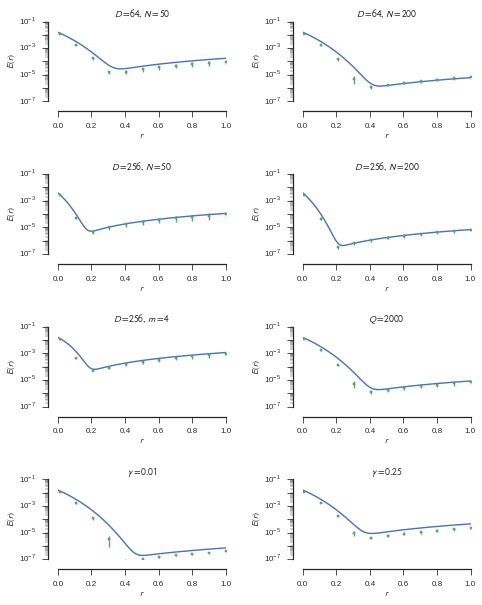

In [11]:
fig = plt.figure(figsize=four_by_two_size)
xs = np.linspace(0, 1, 100)
aggregate_data = []

for i, ((d, N), g) in enumerate(errors.groupby(['dimensions', 'N'])):
    estimate = lambda x: SubvectorRadiusOptimizer(N, 1).sp_subvector_error(x, d)
    data = g.groupby('r')['mse'].agg({'mean': np.mean, 'se': lambda x: 1.96 * np.std(x) / np.sqrt(len(x))})
    data['diff'] = data['mean'] - estimate(data.index.values)
    aggregate_data.append(data)    

    plt.subplot(4, 2, i + 1)
    plt.plot(xs, estimate(xs))
    plt.errorbar(data.index, data['mean'], data['se'], fmt='.', capsize=0)
    plt.semilogy()
    
    plt.title(r"$D={},\ N={}$".format(d, N))
    plt.xlabel(r"$r$", labelpad=labelpad)
    plt.ylabel(r"$E(r)$", labelpad=labelpad)
    plt.ylim(1e-7, 1e-1)
    
    sns.despine(ax=plt.gca(), offset=10)
    for label in plt.gca().get_yticklabels()[::2]:
        label.set_visible(False)

errors2 = pd.DataFrame(load_results('../../data/math-paper/empirical_error2/result.h5'))
datasets = [
    (r"$D=256,\ m=4$",
     lambda x: SubvectorRadiusOptimizer(200, 4).sp_subvector_error(x, 256, 4),
     'dimensions == 256 and m == 4 and n_eval_points == 750 and reg == 0.1'),
    (r"$Q=2000$",
     lambda x: SubvectorRadiusOptimizer(200, 1, ens_kwargs=dict(n_eval_points=2000)).sp_subvector_error(x, 64),
     'dimensions == 64 and m == 1 and n_eval_points == 2000 and reg == 0.1'),
    (r"$\gamma=0.01$",
     lambda x: SubvectorRadiusOptimizer(200, 1, conn_kwargs=dict(solver=nengo.solvers.LstsqL2(reg=0.01))).sp_subvector_error(x, 64),
     'dimensions == 64 and m == 1 and n_eval_points == 750 and reg == 0.01'),
    (r"$\gamma=0.25$",
     lambda x: SubvectorRadiusOptimizer(200, 1, conn_kwargs=dict(solver=nengo.solvers.LstsqL2(reg=0.25))).sp_subvector_error(x, 64),
     'dimensions == 64 and m == 1 and n_eval_points == 750 and reg == 0.25'),
]

for i, (title, estimate, q) in enumerate(datasets):
    data = errors2.query(q).groupby('r')['mse'].agg({'mean': np.mean, 'se': lambda x: 1.96 * np.std(x) / np.sqrt(len(x))})
    data['diff'] = data['mean'] - estimate(data.index.values)
    aggregate_data.append(data)
    
    ax = fig.add_subplot(4, 2, i + 5)
    ax.plot(xs, estimate(xs))
    ax.errorbar(data.index, data['mean'], data['se'], fmt='.', capsize=0)
    ax.semilogy()
        
    ax.set_title(title)
    ax.set_xlabel(r"$r$", labelpad=labelpad)
    ax.set_ylabel(r"$E(r)$", labelpad=labelpad)
    ax.set_ylim(1e-7, 1e-1)

    sns.despine(ax=ax, offset=10)
    for label in ax.get_yticklabels()[::2]:
        label.set_visible(False)

fig.tight_layout(pad=2)

In [12]:
data = pd.concat(aggregate_data)['diff']
print 'mean', np.mean(data)
print 'abs mean', np.mean(np.abs(data))
print 'std', np.std(data)
print 'RMSE', np.sqrt(np.mean(np.square(data)))
print 'abs std', np.std(np.abs(data))
np.mean(pd.concat(aggregate_data))

mean -0.000257956943392
abs mean 0.000259534769141
std 0.000531362464146
RMSE 0.000590667294631
abs std 0.000530593588874


se      0.000079
mean    0.001031
diff   -0.000258
dtype: float64

In [13]:
fig.savefig('empirical-error.eps')

# Representational accuracy

In [14]:
fig = plot_accuracy_dists('repr')

NoSuchNodeError: group ``/`` does not have a child named ``/psyrun``

In [15]:
fig.savefig('../../../spaopt-paper/figures/repr.eps')

# Circular convolution accuracy

n_neurons  d  
50         64     1.831110
200        64     1.428293
           256    1.416341
Name: value, dtype: float64


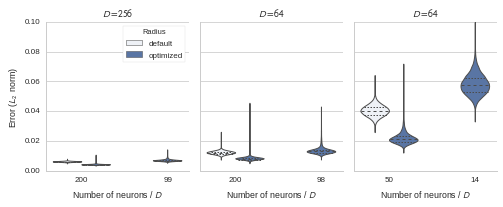

In [16]:
fig = plot_accuracy_dists('cconv')

In [17]:
fig.savefig('../../../spaopt-paper/figures/cconv.eps')

# Dot Product accuracy

n_neurons  d  
50         64     10.971858
200        64      6.637555
           256    25.674939
Name: value, dtype: float64


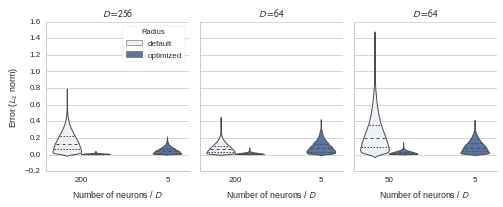

In [18]:
fig = plot_accuracy_dists('dot')

In [19]:
fig.savefig('../../../spaopt-paper/figures/dot.eps')

# SpiNNaker representational accuracy

n_neurons  d 
200        25    1.287022
Name: value, dtype: float64


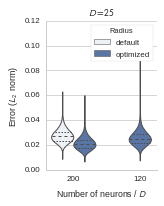

In [20]:
fig = plot_accuracy_dists('spinn_repr')

In [21]:
fig.savefig('../../../spaopt-paper/figures/spinn_repr.eps')